In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
def get_unique_value_lengths(dataframe: pd.DataFrame, col_name: str):
    unique_vals = map(lambda r: str(r), dataframe[col_name].unique())
    unique_vals = filter(lambda r: r != 'nan', unique_vals)
    unique_vals = map(lambda r: len(r), unique_vals)
    unique_vals = list(unique_vals)
    return np.array(unique_vals)

def inferred_type(dataframe: pd.DataFrame, col_name: str, max_cat_value_count: int=1000) -> np.dtype:
    is_datetime_col = dataframe[col_name].str.match('(\d{2,4}(-|\/|\\|\.| )\d{2}(-|\/|\\|\.| )\d{2,4})+').all()
    if is_datetime_col:
        return 'datetime'
    
    is_int32 = dataframe[col_name].str.match('\d{1,6}$').all()
    if is_int32:
        return 'int32'
    
    is_float = dataframe[col_name].str.match(r'\d{1,6}(\.\d{1,5})?$').all()
    if is_float:
        return 'float'
    
    unique_vals = dataframe[col_name].unique()
    n_unique = unique_vals.shape[0]

    if n_unique == 2 or n_unique == 3:
        bool_vals = np.array(['(N/A)', 'N', 'Y'], dtype='str')
        possible_bool_vals = np.array(pd.DataFrame(unique_vals).fillna('(N/A)')[0])
        if np.isin(possible_bool_vals, bool_vals).all():
            return 'bool'
    
    if n_unique >= 2 and n_unique < max_cat_value_count:
        unique_val_lengths = get_unique_value_lengths(dataframe, col_name)
        if np.max(unique_val_lengths) > 300:
            # print(f'{col_name} -> {np.max(unique_val_lengths)}')
            return 'object'
        return 'category'

    return 'object'

def filter_rows(dataframe: pd.DataFrame, min_count_per_category: int=50):
    # Count number of rows per category
    df_count_by_category = dataframe.groupby('category_name').agg({'id': 'count'}).rename(columns={'id': 'n_rows'})

    # Find categories with at least N amount of rows
    categories = list(df_count_by_category[df_count_by_category.n_rows > min_count_per_category].index)

    # Delete rows with few that N amount of rows per category
    return dataframe[dataframe.category_name.isin(categories)]

def filter_columns(dataframe: pd.DataFrame, min_count_per_feature:int=10):
    # Get columns that specify features of the products
    product_feature_columns = list(dataframe.columns)[26:]

    # Find columns that have too few specified values
    n_rows = dataframe.shape[0]
    excluded_cols = []
    for col in product_feature_columns:
        n_filled = n_rows - dataframe[col].isna().sum()
        if n_filled < min_count_per_feature:
            excluded_cols.append(col)
        else:
            # For categorical attributes apply a heuristic that filters
            # out product features with low fill/unique ratios
            dtype = inferred_type(dataframe, col)
            if dtype == 'category':
                n_unique = len(dataframe[col].unique())
                fill_unique_ratio = n_filled / n_unique
                if fill_unique_ratio < 2.0:
                    excluded_cols.append(col)
    
    # Manually exclude certains columns if they were not caught by the
    # heuristic above.
    excluded_cols += [
        'Customs product code (TARIC)',
        'Master (outer) case GTIN (EAN/UPC)',
        'Bundled software',
        'Shipping (inner) case GTIN (EAN/UPC)',
        'Dimensions (W x D x H) (imperial)',
        'Dimensions printer compartment (W x D x H)',
        'Package dimensions (W x D x H)',
        'Interior dimensions (W x D x H)',
        'Package dimensions (WxDxH)',
        'Dimensions (WxDxH)',
        'Exterior dimensions (WxDxH)',
        'Weight (imperial)',
    ]

    # Find columns that have enough values
    product_features_to_use = [col for col in product_feature_columns if col not in excluded_cols]
    
    # Create a copy
    return dataframe[['supplier_name'] + product_features_to_use].copy()

def detect_and_fix_column_types(dataframe: pd.DataFrame):
    df_cleaned = dataframe.copy()
    # Use proper dtypes
    for col in df_cleaned.columns:
        dtype = inferred_type(df_cleaned, col)
        if dtype == 'int32':
            df_cleaned[col].fillna(0, inplace=True)
        elif dtype == 'float':
            df_cleaned[col].fillna(0.0, inplace=True)
        elif dtype == 'bool':
            df_cleaned[col].fillna('N', inplace=True)
            df_cleaned[col] = df_cleaned[col].str.replace('N', '0')
            df_cleaned[col] = df_cleaned[col].str.replace('Y', '1')
            df_cleaned[col] = df_cleaned[col].astype('int')
        elif dtype == 'category':
            df_cleaned[col].fillna('(N/A)', inplace=True)
        df_cleaned[col] = df_cleaned[col].astype(dtype)
    return df_cleaned

def split_train_test(df):
    train = df.sample(frac=.8, random_state=42)
    test = df.loc[~df.index.isin(train.index)]
    return train, test

def compute_column_stats(dataframe: pd.DataFrame):
    dmap = {
        'column': [],
        'suggested_type': [],
        'n_unique': [],
        'len_total': [],
        'len_min': [],
        'len_max': [],
        'len_avg': [],
        'values': [],
        'n_filled': [],
    }

    n_rows = dataframe.shape[0]

    for col in dataframe.columns:
        dmap['column'].append(col)
        dmap['suggested_type'].append(inferred_type(dataframe, col))

        dmap['n_filled'].append( n_rows - dataframe[col].isna().sum() )

        dmap['n_unique'].append(dataframe[col].unique().shape[0])
        unique_val_lengths = get_unique_value_lengths(dataframe, col)
        dmap['len_total'].append(len(unique_val_lengths))
        dmap['len_min'].append(np.min(unique_val_lengths))
        dmap['len_max'].append(np.max(unique_val_lengths))
        dmap['len_avg'].append(np.mean(unique_val_lengths))

        vals = ' | '.join([str(s) for s in list(dataframe[col].unique())[0:5]])
        dmap['values'].append(vals)

    return pd.DataFrame(dmap)

def create_variance_scree_plot(variance_ratios):
    n_items = len(variance_ratios)
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.plot(np.arange(1, n_items + 1), np.cumsum(variance_ratios))
    ax.bar(np.arange(1, n_items + 1), variance_ratios)
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Cumulative Explained Variance');

def find_top_n_categories(dataframe: pd.DataFrame, top_n: int=10):
    return list(dataframe
        .groupby(['category_name'])
        .count()[['id']]
        .sort_values('id', ascending=False)
        .head(top_n)
        .index
    )

In [3]:
# Load data
df_data = pd.read_csv('../data/ice-cat-office-products.csv.gz', dtype=str, index_col=0)

In [4]:
df_data.shape

(7969, 1230)

In [5]:
top_10_categories = find_top_n_categories(df_data, top_n=10)
top_10_categories

['Folders',
 'Self-Adhesive Labels',
 'Multimedia Carts & Stands',
 'Calculators',
 'Writing Notebooks',
 'Ring Binders',
 'Printer Cabinets & Stands',
 'Whiteboards',
 'Fax Machines',
 'File Storage Boxes']

In [6]:
# Filter out small product categories
df_data = df_data[df_data.category_name.isin(top_10_categories)]

In [7]:
df_data.shape

(3075, 1230)

In [8]:
df_cleaned_data = filter_rows(df_data)
df_cleaned_data = filter_columns(df_cleaned_data)

In [9]:
df_column_stats = compute_column_stats(df_cleaned_data)

In [10]:
df_column_stats.to_excel('../data/column-stats.xlsx')

In [11]:
# Clean data
df_cleaned_data = detect_and_fix_column_types(df_cleaned_data)

In [12]:
df_cleaned_data.shape

(3075, 255)

## Vectorise Tabular Data

In [13]:
# Determine categorical and numerical features
dt = df_cleaned_data.dtypes
numeric_features = list(dt[dt==int].index) + list(dt[dt==float].index)
categorical_features = list(dt[dt=="category"].index)

# Create data preprocessor
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [14]:
# Preprocess data
X = preprocessor.fit_transform(df_cleaned_data)

In [15]:
X.shape

(3075, 875)

## Dimenstionality Reduction

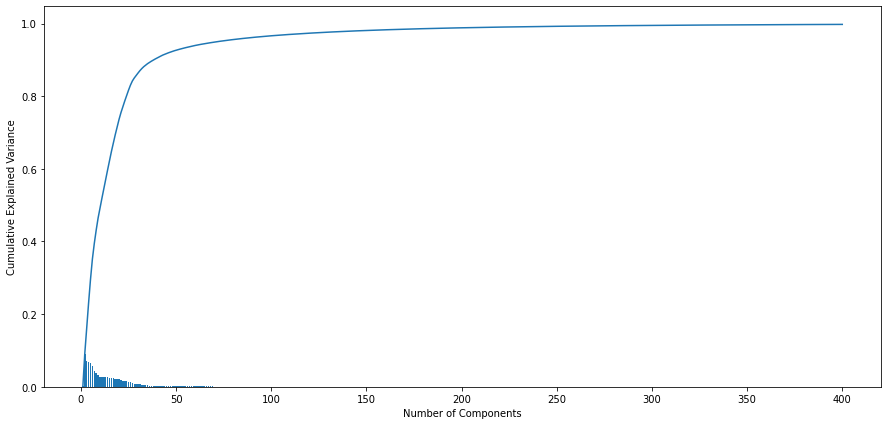

In [16]:
# Reduce number of dimensionality
svd = TruncatedSVD(n_components=400, n_iter=10, random_state=42)
X_transformed = svd.fit_transform(X)

# Generate scree plot
create_variance_scree_plot(svd.explained_variance_ratio_)

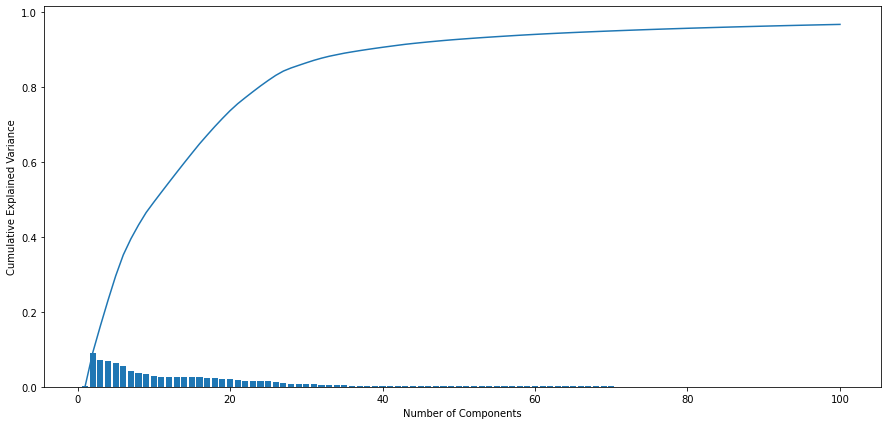

In [17]:
# Further dimensionality reduction
svd = TruncatedSVD(n_components=100, n_iter=10, random_state=42)
X_transformed = svd.fit_transform(X)

# Generate scree plot
create_variance_scree_plot(svd.explained_variance_ratio_)

In [18]:
X_transformed

array([[ 9.30659817e+00, -5.35651093e-01,  1.34431738e-01, ...,
        -1.02715760e-01,  1.30921191e-01,  4.62044205e-02],
       [ 9.29634546e+00,  6.06759038e-01, -2.48940954e-01, ...,
        -2.94038636e-02,  8.56435385e-03,  9.80306263e-02],
       [ 9.30397528e+00, -5.39078835e-01,  1.33973051e-01, ...,
        -3.38431195e-01, -2.14416582e-01, -7.45469613e-03],
       ...,
       [ 8.79447521e+00,  3.41786877e+00,  5.95006180e-01, ...,
        -1.00291752e-01, -1.02366689e-01, -2.46057115e-01],
       [ 8.89333377e+00,  4.65590550e+00,  8.40286628e-01, ...,
        -1.12657148e-01, -2.71891426e-01, -7.60372091e-02],
       [ 8.79355884e+00,  4.13456806e+00,  6.76421739e-01, ...,
        -1.19290495e-01, -1.34864709e-01, -2.70498171e-01]])

In [19]:
X_transformed.shape

(3075, 100)

## Clustering

In [20]:
n_labels = len(df_data.category_name.unique())
n_labels

10

In [21]:
clustering = SpectralClustering(
    n_clusters=n_labels,
    assign_labels='discretize',
    affinity='rbf',
    random_state=42,
    verbose=10
)

In [22]:
clustering.fit(X_transformed)

/home/omar/.cache/pypoetry/virtualenvs/snow-leopard-O1gqMmLm-py3.8/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Computing label assignment using discretize


SpectralClustering(assign_labels='discretize', n_clusters=10, random_state=42,
                   verbose=10)

In [23]:
len(clustering.labels_)

3075

In [24]:
# Set cluster assignments on the DataFrame containing training data
df_cleaned_data['cluster'] = clustering.labels_

In [25]:
# Create a new column in the original DataFrame
df_data['cluster'] = None

# Copy cluster assignments from training DataFrame
df_data['cluster'] = df_cleaned_data['cluster'].astype(int)

## Analysis of Cluster Results

In [26]:
# Export data for analysis in Excel
export_cols = [
    'title', 'supplier_name', 'model_name',
    'description_short',  'category_name', 'cluster'
]
df_data[export_cols].to_excel('../data/ice-cat-products-clusters.xlsx')

In [38]:
df_data.groupby('cluster').agg({'id': 'count'})

,id
cluster,
1,1
2,3039
3,20
6,15


In [41]:
df_data.groupby(['category_name', 'cluster']).agg({'id': 'count'})

id
category_name             cluster     
Calculators               1          1
                          2        304
Fax Machines              2        200
                          3          6
                          6          4
File Storage Boxes        2        191
                          6          1
Folders                   2        645
Multimedia Carts & Stands 2        299
                          3         13
                          6          5
Printer Cabinets & Stands 2        250
                          6          2
Ring Binders              2        298
Self-Adhesive Labels      2        321
                          6          3
Whiteboards               2        232
Writing Notebooks         2        299
                          3          1